# DATA PROCESSING

Wczytujemy dane z pliku CSV, jawnie określając typy kolumn. Jeśli godzina w czasie odjazdu lub przyjazdu przekracza 24, jest przeliczana na pełne doby i konwertowana na format Timestamp.

In [4]:
import pandas as pd

def parse_extended_time(tstr):
    h, m, s = tstr.split(':')
    h, m, s = int(h), int(m), int(s)

    day_offset = h // 24
    hour_in_day = h % 24

    base_date = pd.Timestamp(year=2025, month=1, day=1)
    date_time = base_date + pd.Timedelta(days=day_offset, hours=hour_in_day, minutes=m, seconds=s)

    return date_time

# Wczytanie pliku CSV z jawnym określeniem typów
df = pd.read_csv(
    "connection_graph.csv",
    dtype={
        "id": "int64",
        "company": "string",
        "line": "string", 
        "start_stop": "string",
        "end_stop": "string",
        "start_stop_lat": "float64",
        "start_stop_lon": "float64",
        "end_stop_lat": "float64",
        "end_stop_lon": "float64"
    },
    low_memory=False 
)

# Konwersja czasów
df["departure_time"] = df["departure_time"].apply(parse_extended_time)
df["arrival_time"] = df["arrival_time"].apply(parse_extended_time)

# Sprawdzenie typów
print(df.dtypes)
print(df.head())

Unnamed: 0                 int64
company           string[python]
line              string[python]
departure_time    datetime64[ns]
arrival_time      datetime64[ns]
start_stop        string[python]
end_stop          string[python]
start_stop_lat           float64
start_stop_lon           float64
end_stop_lat             float64
end_stop_lon             float64
dtype: object
   Unnamed: 0       company line      departure_time        arrival_time  \
0           0  MPK Autobusy    A 2025-01-01 20:52:00 2025-01-01 20:53:00   
1           1  MPK Autobusy    A 2025-01-01 20:53:00 2025-01-01 20:54:00   
2           2  MPK Autobusy    A 2025-01-01 20:54:00 2025-01-01 20:55:00   
3           3  MPK Autobusy    A 2025-01-01 20:55:00 2025-01-01 20:57:00   
4           4  MPK Autobusy    A 2025-01-01 20:57:00 2025-01-01 20:59:00   

             start_stop              end_stop  start_stop_lat  start_stop_lon  \
0   Zajezdnia Obornicka              Paprotna       51.148737       17.021069   
1   

### Tworzenie klasy Connection i Stop

Definiujemy klasę Connection, która odpowiada za połączenie między przystankami, przechowując informacje o linii, punktach początkowym i końcowym oraz czasie podróży. Definiujemy także klasę Stop, reprezentującą przystanek z nazwą, współrzędnymi i listą dostępnych połączeń.

In [5]:


class Connection:
    def __init__(self, line, start, end, departure_time, arrival_time):
        self.line = line
        self.start: Stop = start 
        self.end: Stop = end  
        self.departure_time = departure_time
        self.arrival_time = arrival_time
        self.travel_time = (arrival_time - departure_time).total_seconds()
        
    def __repr__(self):
        return (f"Connection({self.line}, {self.start.name} -> {self.end.name}, "
                f"{self.departure_time.strftime('%H:%M:%S')} - {self.arrival_time.strftime('%H:%M:%S')})")


class Stop:
    def __init__(self, name, lat, lon):
        self.name = name
        self.lat = lat
        self.lon = lon
        self.connections: Connection = []

    def add_connection(self, connection):
        self.connections.append(connection)

    def __repr__(self):
        return f"Stop({self.name}, {self.lat}, {self.lon})"

### Tworzenie grafu 

Tworzymy graf, w którym węzłami są przystanki (obiektu Stop), a krawędziami połączenia (Connection) między nimi. Iterujemy przez df, dodając brakujące przystanki do stop_graph i tworząc połączenia z informacjami o linii, godzinach odjazdu i przyjazdu. 

In [6]:
stop_graph = {}
for _, row in df.iterrows():
    start_name = row["start_stop"]
    end_name = row["end_stop"]
    
    if start_name not in stop_graph:
        stop_graph[start_name] = Stop(start_name, row["start_stop_lat"], row["start_stop_lon"])
    if end_name not in stop_graph:
        stop_graph[end_name] = Stop(end_name, row["end_stop_lat"], row["end_stop_lon"])
    
    connection = Connection(
        line=row["line"],
        start=stop_graph[start_name],
        end=stop_graph[end_name],
        departure_time=row["departure_time"],
        arrival_time=row["arrival_time"]
    )
    
    stop_graph[start_name].add_connection(connection)


# Zad1a - algorytm Dijkstry

Funkcja find_earliest_connection wyszukuje najwcześniejsze możliwe połączenie z listy dostępnych, uwzględniając czas przesiadki, jeśli zmienia się linia. Napisaliśmy algorytm Dijkstry zoptymalizowany pod kątem minimalizacji czasu podróży, wykorzystujący kolejkę priorytetową (heapq).

In [7]:
import heapq
import time
from datetime import datetime, timedelta

def find_earliest_connection(connections, current_time, previous_line=None, boarding_time=1):

    transfer_delta = timedelta(minutes=boarding_time)
    earliest = None
    for conn in connections:
        # Jeśli nie jeździmy tą samą linią, trzeba doliczyć czas transferu.
        required_departure = current_time if (previous_line is None or conn.line == previous_line) else current_time + transfer_delta
        if conn.departure_time >= required_departure:
            if earliest is None or conn.departure_time < earliest.departure_time:
                earliest = conn
    return earliest



class DijkstraRouter:
    def __init__(self, stop_graph):
        self.stop_graph = stop_graph

    def _validate_stops(self, start_stop, end_stop):
        if start_stop not in self.stop_graph or end_stop not in self.stop_graph:
            print("ERROR: Przystanek startowy lub końcowy nie istnieje w grafie.")
            return False
        return True

    def _initialize_search_structures(self, start_stop, start_time):
        base_date = datetime(2025, 1, 1)
        start_datetime = base_date.replace(hour=start_time.hour, minute=start_time.minute, second=start_time.second)
        
        travel_times = {name: float('inf') for name in self.stop_graph}
        previous = {name: None for name in self.stop_graph}
        arrival_times = {name: None for name in self.stop_graph}
        previous_lines = {name: None for name in self.stop_graph}
        
        travel_times[start_stop] = 0
        arrival_times[start_stop] = start_datetime
        
        return travel_times, previous, arrival_times, previous_lines, start_datetime

    def _group_connections_by_destination(self, current_stop):
        grouped_connections = {}
        for conn in current_stop.connections:
            destination = conn.end.name
            if destination not in grouped_connections:
                grouped_connections[destination] = []
            grouped_connections[destination].append(conn)
        return grouped_connections

    def _reconstruct_route(self, previous, end_stop):
        route = []
        current = end_stop
        while current and previous[current]:
            prev_stop, conn = previous[current]
            route.append(conn)
            current = prev_stop
        route.reverse()
        return route

    def find_route(self, start_stop, end_stop, start_time, boarding_time=1):

        if not self._validate_stops(start_stop, end_stop):
            return None

        start_measure = time.time()

        # Inicjalizacja struktur wyszukiwania
        travel_times, previous, arrival_times, previous_lines, current_time = self._initialize_search_structures(start_stop, start_time)
        
        # Kolejka priorytetowa (open set) dla algorytmu Dijkstry
        open_set = [(0, start_stop)]
        # Zbiór odwiedzonych węzłów (closed set)
        closed_set = set()

        visited_edges = 0  # Licznik odwiedzonych krawędzi
        visited_nodes = 0  # Licznik odwiedzonych węzłów
        
        while open_set:
            current_travel_time, current_stop_name = heapq.heappop(open_set)
            
            # Jeśli przystanek już był przetwarzany, pomijamy go
            if current_stop_name in closed_set:
                continue
            
            # Dodajemy przystanek do zbioru zamkniętych
            closed_set.add(current_stop_name)
            visited_nodes += 1  # Zwiększ licznik odwiedzonych węzłów
            
            # Jeśli dotarliśmy do celu, przerywamy pętlę
            if current_stop_name == end_stop:
                break
            
            current_stop = self.stop_graph[current_stop_name]
            current_arrival_time = arrival_times[current_stop_name]
            current_line = previous_lines[current_stop_name]
            
            # Grupowanie połączeń wg przystanków docelowych
            grouped_connections = self._group_connections_by_destination(current_stop)
            
            for next_stop_name, conns in grouped_connections.items():
                # Znajdź najwcześniejsze połączenie z uwzględnieniem zasad przesiadek
                earliest_conn = find_earliest_connection(
                    conns, current_arrival_time, 
                    previous_line=current_line, 
                    boarding_time=boarding_time
                )
                
                if earliest_conn is None:
                    continue
                
                travel_time = (earliest_conn.arrival_time - current_arrival_time).total_seconds() / 60
                
                # Aktualizujemy tylko, jeśli znaleziono szybszą trasę
                if current_travel_time + travel_time < travel_times[next_stop_name]:
                    travel_times[next_stop_name] = current_travel_time + travel_time
                    previous[next_stop_name] = (current_stop_name, earliest_conn)
                    arrival_times[next_stop_name] = earliest_conn.arrival_time
                    previous_lines[next_stop_name] = earliest_conn.line
                    
                    heapq.heappush(open_set, (travel_times[next_stop_name], next_stop_name))
                    visited_edges += 1  # Zwiększ licznik odwiedzonych krawędzi
        
        end_measure = time.time()
          
        if travel_times[end_stop] == float('inf'):
            print("DEBUG: Brak dostępnej trasy!")
            return None
        
        # Rekonstrukcja trasy
        route = self._reconstruct_route(previous, end_stop)

        transfer_count = 0
        for i in range(1, len(route)):
            if route[i].line != route[i-1].line:
                transfer_count += 1
        

        
        return {
            'route': route,
            'total_cost': travel_times[end_stop],
            'calculation_time': end_measure - start_measure,
            'transfers': transfer_count,
            'visited_nodes': visited_nodes,
            'visited_edges': visited_edges
        }







Funkcje do wyswietlania wyników

In [8]:
# --- Użycie routera ---
def find_and_print_route(router, start_stop, end_stop, start_time_str):
    start_time = datetime.strptime(start_time_str, "%H:%M:%S")
    result = router.find_route(start_stop, end_stop, start_time)
    
    if result:
        print("\nHarmonogram przejazdu:")
        for connection in result['route']:
            print(f"Linia: {connection.line}, "
                  f"Z: {connection.start.name} o {connection.departure_time.strftime('%H:%M:%S')}, "
                  f"Do: {connection.end.name} o {connection.arrival_time.strftime('%H:%M:%S')}")
        print(f"Liczba przesiadek: {result['transfers']}")
        print(f"\nKoszt trasy (min): {result['total_cost']}")
        print(f"Czas obliczeń: {result['calculation_time']:.4f} sekund")
    else:
        print("Nie znaleziono trasy.")


def find_and_print_simple_route(router, start_stop, end_stop, start_time_str):
    start_time = datetime.strptime(start_time_str, "%H:%M:%S")
    result = router.find_route(start_stop, end_stop, start_time)
    
    if result:
        print("\n=== Przejazd od punktu A do B ===")
        print(f"Start: {start_stop}")
        print(f"Cel: {end_stop}\n")
        
        used_lines = {}  # Przechowuje linie i ich przystanki początkowe/końcowe
        for connection in result['route']:
            line = connection.line
            if line not in used_lines:
                used_lines[line] = {
                    "start": connection.start.name,
                    "departure_time": connection.departure_time.strftime('%H:%M:%S'),
                    "end": connection.end.name,
                    "arrival_time": connection.arrival_time.strftime('%H:%M:%S')
                }
            else:
                used_lines[line]["end"] = connection.end.name
                used_lines[line]["arrival_time"] = connection.arrival_time.strftime('%H:%M:%S')

        print("=== Harmonogram linii ===")
        for line, stops in used_lines.items():
            print(f"Linia {line}: {stops['start']} ({stops['departure_time']}) ➝ {stops['end']} ({stops['arrival_time']})")
        
        print("\nLiczba przesiadek:", result['transfers'])
        print(f"Koszt trasy: {result['total_cost']} min")
        print(f"Czas obliczeń: {result['calculation_time']:.4f} sek\n")
    else:
        print("Nie znaleziono trasy.")


router = DijkstraRouter(stop_graph)
find_and_print_simple_route(router, "Wilczyce - Sosnowa", "Kołobrzeska", "7:00:00")



=== Przejazd od punktu A do B ===
Start: Wilczyce - Sosnowa
Cel: Kołobrzeska

=== Harmonogram linii ===
Linia 911: Wilczyce - Sosnowa (07:10:00) ➝ C.H. Korona (07:25:00)
Linia 131: C.H. Korona (07:26:00) ➝ Brücknera (07:27:00)
Linia 128 : Brücknera (07:29:00) ➝ KROMERA (07:35:00)
Linia 116 : KROMERA (07:36:00) ➝ Kasprowicza (07:39:00)
Linia 118: Kasprowicza (07:42:00) ➝ most Milenijny (07:55:00)
Linia 104: most Milenijny (07:56:00) ➝ Kwiska (08:02:00)
Linia 122: Kwiska (08:03:00) ➝ KUŹNIKI (08:12:00)
Linia 129: KUŹNIKI (08:14:00) ➝ Kołobrzeska (08:15:00)

Liczba przesiadek: 7
Koszt trasy: 75.0 min
Czas obliczeń: 1.7236 sek



# Algorytm A*

Stworzyliśmy funkcję AStarRouter, która implementuje algorytm A* do wyznaczania optymalnej trasy na podstawie czasu podróży. Klasa przyjmuje jako argument funkcję heurystyczną, która wpływa na wybór kolejnych przystanków w procesie wyszukiwania.

In [9]:
class AStarRouter:
    def __init__(self, stop_graph, heuristic_function):
        self.stop_graph = stop_graph
        self.heuristic = heuristic_function

    def _validate_stops(self, start_stop, end_stop):
        # Sprawdzenie, czy przystanki początkowy i końcowy istnieją w grafie
        if start_stop not in self.stop_graph or end_stop not in self.stop_graph:
            print("ERROR: Przystanek startowy lub końcowy nie istnieje w grafie.")
            return False
        return True

    def _initialize_search_structures(self, start_stop, start_time):
        # Inicjalizacja struktur danych potrzebnych do wyszukiwania trasy
        base_date = datetime(2025, 1, 1)
        start_datetime = base_date.replace(hour=start_time.hour, minute=start_time.minute, second=start_time.second)
        
        travel_times = {name: float('inf') for name in self.stop_graph}
        previous = {name: None for name in self.stop_graph}
        arrival_times = {name: None for name in self.stop_graph}
        previous_lines = {name: None for name in self.stop_graph}
        
        travel_times[start_stop] = 0
        arrival_times[start_stop] = start_datetime
        
        return travel_times, previous, arrival_times, previous_lines, start_datetime

    def _group_connections_by_destination(self, current_stop):
        # Grupowanie połączeń według przystanków docelowych
        grouped_connections = {}
        for conn in current_stop.connections:
            destination = conn.end.name
            if destination not in grouped_connections:
                grouped_connections[destination] = []
            grouped_connections[destination].append(conn)
        return grouped_connections

    def _reconstruct_route(self, previous, end_stop):
        # Odtwarzanie trasy na podstawie poprzednich przystanków
        route = []
        current = end_stop
        while current and previous[current]:
            prev_stop, conn = previous[current]
            route.append(conn)
            current = prev_stop
        route.reverse()
        return route

    def find_route(self, start_stop, end_stop, start_time, boarding_time=1):
        # Główna metoda wyszukiwania trasy
        if not self._validate_stops(start_stop, end_stop):
            return None

        start_measure = time.time()
        
        travel_times, previous, arrival_times, previous_lines, current_time = self._initialize_search_structures(start_stop, start_time)
        
        open_set = [(0, 0, start_stop)]
        closed_set = set()
        
        visited_edges = 0  # Licznik odwiedzonych krawędzi
        visited_nodes = 0  # Licznik odwiedzonych węzłów

        while open_set:
            current_f, current_g, current_stop_name = heapq.heappop(open_set)
            
            if current_stop_name in closed_set:
                continue
            
            closed_set.add(current_stop_name)
            visited_nodes += 1  # Zwiększ licznik odwiedzonych węzłów
            
            if current_stop_name == end_stop:
                break
            
            current_stop = self.stop_graph[current_stop_name]
            current_arrival_time = arrival_times[current_stop_name]
            current_line = previous_lines[current_stop_name]
            
            grouped_connections = self._group_connections_by_destination(current_stop)
            
            for next_stop_name, conns in grouped_connections.items():
                if next_stop_name in closed_set:
                    continue
                
                # Znajdź najwcześniejsze połączenie
                earliest_conn = find_earliest_connection(conns, current_arrival_time, previous_line=current_line, boarding_time=boarding_time)
                
                if earliest_conn is None:
                    continue
                
                travel_time = (earliest_conn.arrival_time - current_arrival_time).total_seconds() / 60

                heuristic_args = {
                    'current_line': current_line,
                    'next_line': earliest_conn.line,
                    'current_stop': current_stop,
                    'next_stop': self.stop_graph[next_stop_name],
                    'end_stop': self.stop_graph[end_stop],
                    'current_time': current_arrival_time,
                    'start_time': start_time
                }
                heuristic = self.heuristic(**heuristic_args)
                
                new_g = current_g + travel_time
                h_cost = heuristic
                f_cost = new_g + h_cost
                
                if new_g < travel_times[next_stop_name]:
                    travel_times[next_stop_name] = new_g
                    previous[next_stop_name] = (current_stop_name, earliest_conn)
                    arrival_times[next_stop_name] = earliest_conn.arrival_time
                    previous_lines[next_stop_name] = earliest_conn.line
                    
                    heapq.heappush(open_set, (f_cost, new_g, next_stop_name))
                    visited_edges += 1  # Zwiększ licznik odwiedzonych krawędzi
        
        end_measure = time.time()
        
        if travel_times[end_stop] == float('inf'):
            print("DEBUG: Brak dostępnej trasy!")
            return None
        
        route = self._reconstruct_route(previous, end_stop)

        transfer_count = 0
        for i in range(1, len(route)):
            if route[i].line != route[i-1].line:
                transfer_count += 1
        
        # Zwróć szczegóły trasy
        return {
            'route': route,
            'total_cost': travel_times[end_stop],
            'calculation_time': end_measure - start_measure,
            'transfers': transfer_count,
            'visited_nodes': visited_nodes,
            'visited_edges': visited_edges
        }

# Zad1b - Algorytm A* w oparciu o czas przejazdu
Uywamy algorytmy A* z funkcja heurystyczna, która oblicza czas przejazdu na podstawie odległości między przystankami. Jej argumentem jest m.in średnia prędkość która zakładamy, ze wynosi 20km/h.
Funkcja haversine_distance oblicza odległość geograficzną między dwoma punktami na podstawie ich współrzędnych.

In [10]:
from math import radians, sin, cos, sqrt, atan2, degrees

def haversine_distance(lat1, lon1, lat2, lon2):
    # Obliczanie odległości geograficznej między dwoma punktami na podstawie współrzędnych
    R = 6371.0  # Średnia promień Ziemi w km

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance


def time_penalty_function(speed=25, **kwargs):
    # Funkcja heurystyczna obliczająca karę czasową na podstawie odległości i prędkości
    current_stop = kwargs['current_stop']
    end_stop = kwargs['end_stop']
    
    distance = haversine_distance(current_stop.lat, current_stop.lon, end_stop.lat, end_stop.lon)
    
    if distance == 0:
        return 0
    
    time_penalty = distance / speed
    return time_penalty

# Tworzenie routera A* z funkcją heurystyczną opartą na czasie przejazdu
router = AStarRouter(stop_graph, time_penalty_function)
find_and_print_simple_route(router, "Wilczyce - Sosnowa", "Kołobrzeska", "7:00:00")




=== Przejazd od punktu A do B ===
Start: Wilczyce - Sosnowa
Cel: Kołobrzeska

=== Harmonogram linii ===
Linia 911: Wilczyce - Sosnowa (07:10:00) ➝ C.H. Korona (07:25:00)
Linia 131: C.H. Korona (07:26:00) ➝ Brücknera (07:27:00)
Linia 128 : Brücknera (07:29:00) ➝ KROMERA (07:35:00)
Linia 116 : KROMERA (07:36:00) ➝ Kasprowicza (07:39:00)
Linia 118: Kasprowicza (07:42:00) ➝ most Milenijny (07:55:00)
Linia 104: most Milenijny (07:56:00) ➝ Kwiska (08:02:00)
Linia 122: Kwiska (08:03:00) ➝ KUŹNIKI (08:12:00)
Linia 129: KUŹNIKI (08:14:00) ➝ Kołobrzeska (08:15:00)

Liczba przesiadek: 7
Koszt trasy: 75.0 min
Czas obliczeń: 1.0553 sek



# Zad1c - Algorytm A* w oparciu o kryterium przesiadek

Używamy algorytmu A* z funkcją heurystyczną, która uwzględnia karę za przesiadkę. Wielkość tej kary możemy modyfikować, zmieniając parametr transfer_penalty w funkcji transfer_penalty_function, która dodaje karę, jeśli zmienia się linia.

In [23]:
from datetime import datetime, timedelta
import heapq

class AstarRouterForTransfers(AStarRouter):
    def __init__(self, stop_graph, heuristic_function, time_window=120):
        super().__init__(stop_graph, heuristic_function)
        self.time_window = time_window  # nie jest używane w tej wersji, ale zachowujemy dla kompatybilności

    def convert_time(self, time_str: str) -> datetime:
        """Konwertuje napis z godziną (np. '7:00:00') na datetime z ustalonym dniem."""
        base_date = datetime(2025, 1, 1)
        
        if isinstance(time_str, datetime):  # Jeśli już jest datetime, po prostu zwróć
            return time_str.replace(year=2025, month=1, day=1)

        time_obj = datetime.strptime(time_str, "%H:%M:%S")
        return base_date.replace(hour=time_obj.hour, minute=time_obj.minute, second=time_obj.second)


    def haversine_distance_heuristic(self, current_stop: str, target_stop: str) -> float:
        current = self.stop_graph[current_stop]
        target = self.stop_graph[target_stop]
        return haversine_distance(current.lat, current.lon, target.lat, target.lon)

    def find_same_line_connections(self, connections, current_time: datetime, current_line: str):
        same_line_connections = [
            conn for conn in connections 
            if conn.line == current_line and conn.departure_time >= current_time
        ]
        return sorted(same_line_connections, key=lambda x: x.departure_time)

    def find_valid_connections(self, connections, current_time: datetime, current_line: str = None, transfer_time: int = 1):
        valid_connections = []
        for conn in connections:
            required_time = current_time
            if current_line and conn.line != current_line:
                required_time += timedelta(minutes=transfer_time)
            if conn.departure_time >= required_time:
                valid_connections.append(conn)
        return sorted(valid_connections, key=lambda x: x.departure_time)

    def find_route(self, start_stop: str, end_stop: str, departure_time: str, transfer_time: int = 1):
        start_time = self.convert_time(departure_time)

        if start_stop not in self.stop_graph or end_stop not in self.stop_graph:
            return None
        
        start_measure = time.time()

        # Inicjujemy struktury – klucze są krotkami (nazwa_przystanku, linia)
        distances = {}
        arrival_times = {}
        previous = {}
        transfer_counts = {}

        start_key = (start_stop, None)
        distances[start_key] = 0
        arrival_times[start_key] = start_time
        previous[start_key] = None
        transfer_counts[start_key] = 0

        entry_count = 0
        # Kolejka priorytetowa: (liczba_przesiadek, heurystyka, entry_id, przystanek, linia)
        priority_queue = [
            (0, self.haversine_distance_heuristic(start_stop, end_stop), entry_count, start_stop, None)
        ]
        visited_nodes = 0
        visited_connections = 0
        closed_set = set()

        while priority_queue:
            current_transfer_count, _, _, current_stop, current_line = heapq.heappop(priority_queue)
            current_key = (current_stop, current_line)

            # Jeżeli dotarliśmy do celu – nie przerywamy, ale będziemy szukać najlepszej ścieżki
            if current_stop == end_stop:
                # Opcjonalnie można przerwać, ale żeby znaleźć najlepszą ścieżkę, kontynuujemy
                pass

            if current_key in closed_set:
                continue

            closed_set.add(current_key)
            visited_nodes += 1

            current_time = arrival_times[current_key]

            # Grupujemy połączenia z danego przystanku według przystanków docelowych
            grouped_connections = {}
            for conn in self.stop_graph[current_stop].connections:
                dest = conn.end.name
                if dest not in grouped_connections:
                    grouped_connections[dest] = []
                grouped_connections[dest].append(conn)

            for next_stop, connections in grouped_connections.items():
                visited_connections += 1

                # 1. Najpierw próbujemy połączenia tą samą linią (bez przesiadki)
                if current_line is not None:
                    same_line_conns = self.find_same_line_connections(connections, current_time, current_line)
                    if same_line_conns:
                        earliest_conn = same_line_conns[0]
                        new_transfer_count = current_transfer_count  # bez zmiany linii
                        travel_time = (earliest_conn.arrival_time - current_time).total_seconds() / 60
                        new_key = (next_stop, earliest_conn.line)
                        if new_key not in transfer_counts or new_transfer_count < transfer_counts[new_key]:
                            transfer_counts[new_key] = new_transfer_count
                            distances[new_key] = distances[current_key] + travel_time
                            arrival_times[new_key] = earliest_conn.arrival_time
                            previous[new_key] = (current_key, earliest_conn)
                            heuristic = self.haversine_distance_heuristic(next_stop, end_stop)
                            entry_count += 1
                            heapq.heappush(priority_queue, (new_transfer_count, heuristic, entry_count, next_stop, earliest_conn.line))

                # 2. Rozważamy wszystkie ważne połączenia (w tym przesiadki)
                valid_conns = self.find_valid_connections(connections, current_time, current_line, transfer_time)
                for conn in valid_conns:
                    is_transfer = (current_line is not None and conn.line != current_line)
                    new_transfer_count = current_transfer_count + (1 if is_transfer else 0)
                    travel_time = (conn.arrival_time - current_time).total_seconds() / 60
                    if is_transfer:
                        travel_time += transfer_time  # kara za przesiadkę
                    new_key = (next_stop, conn.line)
                    if new_key not in transfer_counts or new_transfer_count < transfer_counts[new_key]:
                        transfer_counts[new_key] = new_transfer_count
                        distances[new_key] = distances[current_key] + travel_time
                        arrival_times[new_key] = conn.arrival_time
                        previous[new_key] = (current_key, conn)
                        heuristic = self.haversine_distance_heuristic(next_stop, end_stop)
                        entry_count += 1
                        heapq.heappush(priority_queue, (new_transfer_count, heuristic, entry_count, next_stop, conn.line))
                
        end_measure = time.time()

        # Szukamy najlepszej ścieżki do celu (klucze, gdzie przystanek = end_stop) o minimalnej liczbie przesiadek
        best_key = None
        min_transfers = float('inf')
        for key, count in transfer_counts.items():
            if key[0] == end_stop and count < min_transfers:
                min_transfers = count
                best_key = key

        if best_key is None:
            return None

        # Rekonstrukcja ścieżki
        route = []
        current_key = best_key
        while current_key and previous.get(current_key) is not None:
            prev_key, conn = previous[current_key]
            route.append(conn)
            current_key = prev_key
        route.reverse()

        total_time = distances.get(best_key, float('inf'))
        return {
            'route': route,
            'total_cost': total_time,
            'calculation_time': end_measure - start_measure,
            'transfers': min_transfers,
            'visited_nodes': visited_nodes,
            'visited_edges': visited_connections

        }


def transfer_penalty_function(transfer_penalty = 30, **kwargs):
    current_line = kwargs['current_line']
    next_line = kwargs['next_line']

    if current_line and current_line != next_line:
        return transfer_penalty
    return 0


router = AstarRouterForTransfers(
    stop_graph, 
    heuristic_function = transfer_penalty_function,
)
find_and_print_simple_route(router, "Wilczyce - Sosnowa", "Kołobrzeska", "7:00:00")


=== Przejazd od punktu A do B ===
Start: Wilczyce - Sosnowa
Cel: Kołobrzeska

=== Harmonogram linii ===
Linia 911: Wilczyce - Sosnowa (07:10:00) ➝ PL. GRUNWALDZKI (07:38:00)
Linia 149: PL. GRUNWALDZKI (07:44:00) ➝ Kołobrzeska (08:17:00)

Liczba przesiadek: 1
Koszt trasy: 78.0 min
Czas obliczeń: 37.9521 sek



# Zad1d - optymalizacja algorytmu A*

Robimy funkcje, które wprowadzają kary za odległość i zmianę kierunku w algorytmie A*. distance_penalty_function dodaje karę za odległość, a direction_penalty_function sprawdza, czy zmienił się kierunek podróży, nakładając karę, jeśli różnica w kierunku przekroczy określony próg. Funkcja hybrid_penalty_function sumuje obie kary, łącząc je w jedną wartość.

In [ ]:

def distance_penalty_function(distance_penalty = 4, **kwargs):
    current_stop = kwargs['current_stop']
    end_stop = kwargs['end_stop']
    distance = haversine_distance(current_stop.lat, current_stop.lon, end_stop.lat, end_stop.lon)
    if distance == 0: 
        return 0
    return distance_penalty * distance



import math

def direction_penalty_function(direction_penalty=15, max_angle_degrees=60, **kwargs):
    current_stop = kwargs['current_stop']
    next_stop = kwargs['next_stop']
    end_stop = kwargs['end_stop']
    
    # Pobierz współrzędne
    current_lat, current_lon = current_stop.lat, current_stop.lon
    next_lat, next_lon = next_stop.lat, next_stop.lon
    end_lat, end_lon = end_stop.lat, end_stop.lon
    
    # Oblicz wektory
    # Wektor od obecnego przystanku do końcowego
    vector_to_end = (end_lat - current_lat, end_lon - current_lon)
    # Wektor od obecnego przystanku do następnego
    vector_to_next = (next_lat - current_lat, next_lon - current_lon)
    
    # Oblicz długości wektorów
    magnitude_to_end = math.sqrt(vector_to_end[0]**2 + vector_to_end[1]**2)
    magnitude_to_next = math.sqrt(vector_to_next[0]**2 + vector_to_next[1]**2)
    
    # Obsłuż przypadek, gdy przystanki znajdują się w tej samej lokalizacji (uniknięcie dzielenia przez zero)
    if magnitude_to_end < 1e-10 or magnitude_to_next < 1e-10:
        return 0
    
    # Oblicz iloczyn skalarny
    dot_product = vector_to_end[0] * vector_to_next[0] + vector_to_end[1] * vector_to_next[1]
    
    # Oblicz kąt w radianach, a następnie przelicz na stopnie
    # cos(kąt) = iloczyn skalarny / (długość1 * długość2)
    cos_angle = dot_product / (magnitude_to_end * magnitude_to_next)
    # Ogranicz wartość do przedziału [-1,1], aby obsłużyć błędy zaokrągleń
    cos_angle = max(-1, min(1, cos_angle))
    angle_rad = math.acos(cos_angle)
    angle_deg = math.degrees(angle_rad)
    
    # Zastosuj karę, jeśli kąt jest większy niż max_angle_degrees
    if angle_deg > max_angle_degrees:
        return direction_penalty
    return 0



def hybrid_penalty_function(**kwargs):
    distance_penalty = distance_penalty_function(**kwargs)
    direction_penalty = direction_penalty_function(**kwargs)
    
    return distance_penalty + direction_penalty

router = AStarRouter(stop_graph, heuristic_function=hybrid_penalty_function)
find_and_print_simple_route(router, "Wilczyce - Sosnowa", "Kołobrzeska", "7:00:00")



=== Przejazd od punktu A do B ===
Start: Wilczyce - Sosnowa
Cel: Kołobrzeska

=== Harmonogram linii ===
Linia 911: Wilczyce - Sosnowa (07:10:00) ➝ C.H. Korona (07:25:00)
Linia 131: C.H. Korona (07:26:00) ➝ Brücknera (07:27:00)
Linia 128 : Brücknera (07:29:00) ➝ KROMERA (07:35:00)
Linia 116 : KROMERA (07:36:00) ➝ Kasprowicza (07:39:00)
Linia 118: Kasprowicza (07:42:00) ➝ most Milenijny (07:55:00)
Linia 104: most Milenijny (07:56:00) ➝ Milenijna (Hala Orbita) (07:57:00)
Linia 134: Milenijna (Hala Orbita) (08:02:00) ➝ Na Ostatnim Groszu (08:06:00)
Linia 129: Na Ostatnim Groszu (08:07:00) ➝ Kołobrzeska (08:15:00)

Liczba przesiadek: 7
Koszt trasy: 75.0 min
Czas obliczeń: 0.2325 sek



# Porównanie wydajności algorytmów
Na koniec porównujemy wydajność algorytmu Dijkstry i A* w różnych scenariuszach, aby ocenić, który z nich jest bardziej efektywny w kontekście wyszukiwania najkrótszej trasy i ilosci przesiadek.

In [20]:
import pandas as pd
import time
from datetime import datetime

# Definiowanie tras
routes = {
    'short_route': ['PL. GRUNWALDZKI', 'PL. JANA PAWŁA II'],
    'medium_route': ['C.H. Korona', 'Husarska'],
    'long_route': ['Wilczyce - Sosnowa', 'Kołobrzeska']
}


# Funkcja do uruchamiania algorytmu i zbierania wyników
def get_algorithm_results(router, route, start_time_str):
    start_time = datetime.strptime(start_time_str, "%H:%M:%S")
    result = router.find_route(route[0], route[1], start_time)
    
    if result:
        total_cost = result['total_cost']
        calculation_time = result['calculation_time']
        
        # Sprawdzenie czy total_cost i calculation_time są liczbami przed zaokrągleniem
        if isinstance(total_cost, (int, float)):
            total_cost = round(total_cost, 4)
        if isinstance(calculation_time, (int, float)):
            calculation_time = round(calculation_time, 4)
        
        return {
            'total_cost': total_cost,
            'calculation_time': calculation_time,
            'transfers': result['transfers']
        }
    else:
        return {
            'total_cost': 'Brak trasy',
            'calculation_time': 'Brak trasy',
            'transfers': 'Brak trasy'
        }

# Przygotowanie tabeli
results = []

# Testowanie algorytmu Dijkstry
for route_name, route in routes.items():
    router = DijkstraRouter(stop_graph)  
    result = get_algorithm_results(router, route, "07:00:00")
    result['algorithm'] = "Dijkstra"
    result['route_name'] = route_name
    results.append(result)

for route_name, route in routes.items():
    router = AstarRouterForTransfers(stop_graph, transfer_penalty_function)
    result = get_algorithm_results(router, route, "07:00:00")
    result['algorithm'] = "A Star For Transfer"
    result['route_name'] = route_name
    results.append(result)

heuristic_functions = [
    transfer_penalty_function,
    time_penalty_function,
    direction_penalty_function,
    distance_penalty_function,
    hybrid_penalty_function, #distance + direction
]

# Testowanie algorytmu A*
for route_name, route in routes.items():
    for heuristic_function in heuristic_functions:
        algorithm = f"A* {heuristic_function.__name__}"  # Tworzymy nazwę algorytmu z nazwy funkcji heurystycznej
        router = AStarRouter(stop_graph, heuristic_function)  # Router A* z odpowiednią heurystyką
        result = get_algorithm_results(router, route, "07:00:00")
        result['algorithm'] = algorithm
        result['route_name'] = route_name
        results.append(result)

# Tworzenie DataFrame z wyników
df = pd.DataFrame(results)

# Filtrowanie po trasach
short_route_df = df[df['route_name'] == 'short_route']
medium_route_df = df[df['route_name'] == 'medium_route']
long_route_df = df[df['route_name'] == 'long_route']

# Wyświetlanie wyników osobno dla każdej trasy
print("Short Route Results:")
print(short_route_df.to_string(index=False))

print("\nMedium Route Results:")
print(medium_route_df.to_string(index=False))

print("\nLong Route Results:")
print(long_route_df.to_string(index=False))


Short Route Results:
 total_cost  calculation_time  transfers                     algorithm  route_name
       16.0            0.6210          2                      Dijkstra short_route
       24.0           37.4123          0           A Star For Transfer short_route
       16.0            0.6352          2  A* transfer_penalty_function short_route
       16.0            0.3333          2      A* time_penalty_function short_route
       16.0            0.1021          2 A* direction_penalty_function short_route
       16.0            0.1837          2  A* distance_penalty_function short_route
       16.0            0.0809          2    A* hybrid_penalty_function short_route

Medium Route Results:
 total_cost  calculation_time  transfers                     algorithm   route_name
       48.0            1.5844          3                      Dijkstra medium_route
     1149.0           35.0491          1           A Star For Transfer medium_route
       48.0            0.8405          2

# Generowanie
Generujemy 20 losowych tras i wyznaczamy dla nich najkrótsze trasy, porównując wyniki algorytmów i liczymy statystyki dotyczące m.in czasu przejazdu, liczby przesiadek i długości trasy.

In [23]:
import random
import pandas as pd
import time
from datetime import datetime, timedelta
import heapq

def generate_test_cases(stop_graph, num_cases=50):
    stop_names = list(stop_graph.keys())
    test_cases = []
    
    # Czasy startu (rano, południe, wieczór)
    start_times = ["07:00:00", "12:00:00", "18:00:00"]
    
    for _ in range(num_cases):
        # Wybierz losowy przystanek początkowy i końcowy (różne od siebie)
        start_stop = random.choice(stop_names)
        end_stop = random.choice([s for s in stop_names if s != start_stop])
        
        # Wybierz losowy czas startu
        start_time = random.choice(start_times)
        
        test_cases.append((start_stop, end_stop, start_time))
    
    return test_cases

def compare_algorithms(stop_graph, test_cases):
    results = []
    
    # Heurystyki dla A*
    heuristic_functions = [
        transfer_penalty_function,
        time_penalty_function,
        distance_penalty_function,
        direction_penalty_function,
        hybrid_penalty_function # distance + direction
    ]
    
    # Dla każdego przypadku testowego
    for i, (start_stop, end_stop, start_time_str) in enumerate(test_cases):
        test_id = f"Test {i+1}: {start_stop} -> {end_stop} ({start_time_str})"
        print(f"Uruchamianie {test_id}...")
        
        # Parsowanie czasu startu
        start_time = datetime.strptime(start_time_str, "%H:%M:%S")
        
        # Testujemy algorytm Dijkstry
        router = DijkstraRouter(stop_graph)
        result = router.find_route(start_stop, end_stop, start_time)
        
        if result:
            # Zbieramy metryki
            results.append({
                'test_id': test_id,
                'algorithm': 'Dijkstra',
                'total_cost': result['total_cost'],
                'calculation_time': round(result['calculation_time'], 4),
                'transfers': result['transfers'],
                'visited_nodes': result.get('visited_nodes', 'N/A'),
                'visited_edges': result.get('visited_edges', 'N/A'),
                'route_length': len(result['route'])
            })
        else:
            print(f"Nie znaleziono trasy dla {test_id} używając Dijkstry")

        
        router = AstarRouterForTransfers(stop_graph, transfer_penalty_function)
        result = router.find_route(start_stop, end_stop, start_time)

        if result:
            # Zbieramy metryki
            results.append({
                'test_id': test_id,
                'algorithm': 'A* For Transfer',
                'total_cost': result['total_cost'],
                'calculation_time': round(result['calculation_time'], 4),
                'transfers': result['transfers'],
                'visited_nodes': result.get('visited_nodes', 'N/A'),
                'visited_edges': result.get('visited_edges', 'N/A'),
                'route_length': len(result['route'])
            })
        
        # Testujemy A* z różnymi heurystykami
        for heuristic_function in heuristic_functions:
            heuristic_name = heuristic_function.__name__
            router = AStarRouter(stop_graph, lambda **kwargs: heuristic_function(transfer_penalty=20, **kwargs))
            
            result = router.find_route(start_stop, end_stop, start_time)
            
            if result:
                # Zbieramy metryki
                results.append({
                    'test_id': test_id,
                    'algorithm': f'A*_{heuristic_name}',
                    'total_cost': result['total_cost'],
                    'calculation_time': round(result['calculation_time'], 4),
                    'transfers': result['transfers'],
                    'visited_nodes': result.get('visited_nodes', 'N/A'),
                    'visited_edges': result.get('visited_edges', 'N/A'),
                    'route_length': len(result['route'])
                })
            else:
                print(f"Nie znaleziono trasy dla {test_id} używając A* z {heuristic_name}")
    
    # Tworzymy DataFrame z wynikami
    df = pd.DataFrame(results)
    
    # Wyświetlamy wyniki
    print("\nWyniki porównania algorytmów:")
    print(df[['test_id', 'algorithm', 'total_cost', 'calculation_time', 'transfers', 'visited_nodes', 'visited_edges']].to_string(index=False))
    
    # Wyświetlamy średnie wyniki dla każdego algorytmu
    print("\nŚrednie wyniki dla algorytmów:")
    avg_results = df.groupby('algorithm').agg({
        'total_cost': 'mean',
        'calculation_time': 'mean',
        'transfers': 'mean',
        'visited_nodes': lambda x: x.mean(),
        'visited_edges': lambda x: x.mean()
    }).reset_index()
    
    print(avg_results.to_string(index=False))
    
    return df

# Przykład użycia:
test_cases = generate_test_cases(stop_graph, num_cases=20)
results_df = compare_algorithms(stop_graph, test_cases)

Uruchamianie Test 1: Gajowicka -> Zielińskiego (18:00:00)...
Uruchamianie Test 2: KARŁOWICE -> Las Osobowicki (07:00:00)...
Uruchamianie Test 3: Urząd Wojewódzki (Impart) -> Smolec - Główna/Dworcowa (12:00:00)...
Uruchamianie Test 4: Pruszowice -> Smolec - Chłopska/Cisowa (18:00:00)...
Uruchamianie Test 5: RATYŃ -> Miękinia - stacja PKP (07:00:00)...
Uruchamianie Test 6: Krucza -> Grudziądzka (12:00:00)...
Uruchamianie Test 7: Błonie -> Łowęcice - Staw (07:00:00)...
Uruchamianie Test 8: Główna -> Kurpiów (07:00:00)...
Uruchamianie Test 9: Hala Stulecia -> ROD Źródło Zdrowia (07:00:00)...
Uruchamianie Test 10: SOŁTYSOWICE -> Kurlandzka (07:00:00)...
Uruchamianie Test 11: Krzeptów - pętla -> Drzewieckiego (12:00:00)...
Uruchamianie Test 12: Bezpieczna -> Kiełczów - pętla (Plac Jana Gdaka) (18:00:00)...
Uruchamianie Test 13: Awicenny (Stacja kolejowa) -> Dolnobrzeska (18:00:00)...
Uruchamianie Test 14: Brzezina - Biedronka -> Joannitów (18:00:00)...
Uruchamianie Test 15: Tymiankowa -> Orz

/var/folders/69/3bgwy7vx3g9g3hc8fwyj9pfh0000gn/T/ipykernel_95483/2766573798.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='algorithm', y='transfers', data=df, palette="pastel")


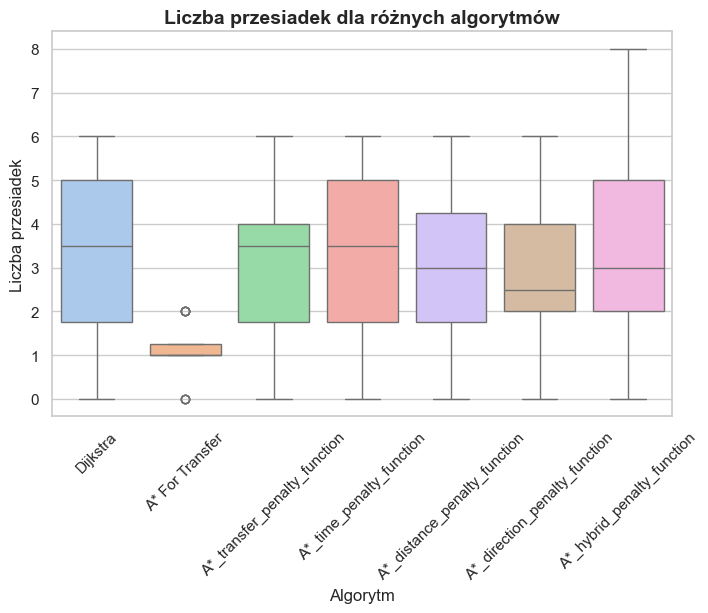

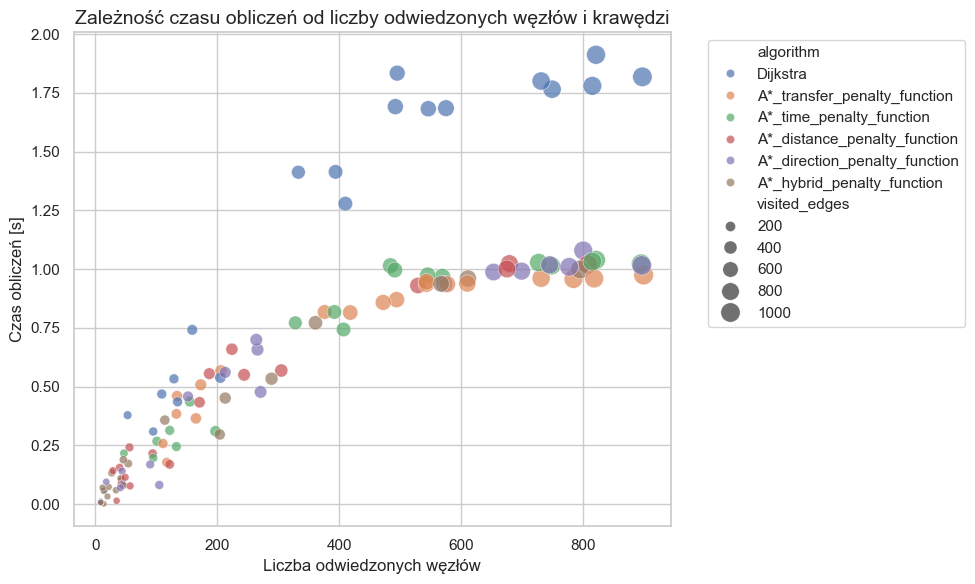

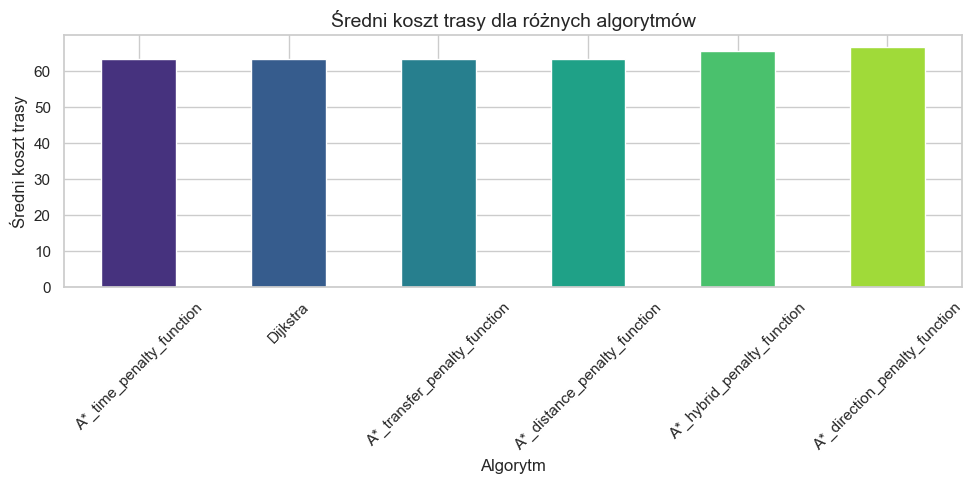

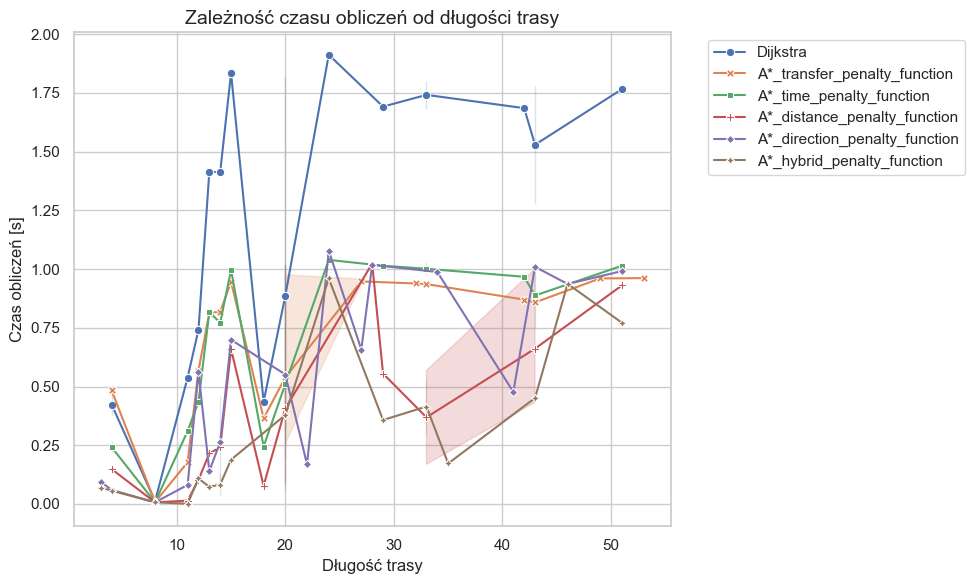

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt


df = results_df
# Ustawienia stylu wykresów
sns.set_theme(style="whitegrid")

# Box plot liczby przesiadek 
plt.figure(figsize=(8, 5))
sns.boxplot(x='algorithm', y='transfers', data=df, palette="pastel")
plt.xticks(rotation=45)
plt.title('Liczba przesiadek dla różnych algorytmów', fontsize=14, fontweight='bold')
plt.xlabel('Algorytm', fontsize=12)
plt.ylabel('Liczba przesiadek', fontsize=12)
plt.show()


df_filtered = df[df['algorithm'] != 'A* For Transfer']

# Wykres sieciowy pokazujący zależność między odwiedzonymi węzłami a czasem obliczeń
plt.figure(figsize=(10, 6))
sns.scatterplot(x='visited_nodes', y='calculation_time', hue='algorithm', 
                size='visited_edges', sizes=(20, 200), alpha=0.7, data=df_filtered)
plt.title('Zależność czasu obliczeń od liczby odwiedzonych węzłów i krawędzi', fontsize=14)
plt.xlabel('Liczba odwiedzonych węzłów', fontsize=12)
plt.ylabel('Czas obliczeń [s]', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# Wykres średnich kosztów tras dla każdego algorytmu
plt.figure(figsize=(10, 5))
avg_costs =  df_filtered.groupby('algorithm')['total_cost'].mean().sort_values()
avg_costs.plot(kind='bar', color=sns.color_palette("viridis", len(avg_costs)))
plt.title('Średni koszt trasy dla różnych algorytmów', fontsize=14)
plt.xlabel('Algorytm', fontsize=12)
plt.ylabel('Średni koszt trasy', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



# Wykres pokazujący jak czas obliczeń rośnie z długością znalezionej trasy
plt.figure(figsize=(10, 6))
sns.lineplot(x='route_length', y='calculation_time', hue='algorithm', 
             style='algorithm', markers=True, dashes=False, data=df_filtered)
plt.title('Zależność czasu obliczeń od długości trasy', fontsize=14)
plt.xlabel('Długość trasy', fontsize=12)
plt.ylabel('Czas obliczeń [s]', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Wizualizacja trasy
Uywamy networkx do wizualizacji grafu przystanków i połączeń. Używamy matplotlib do rysowania grafu, gdzie węzły reprezentują przystanki, a krawędzie połączenia między nimi. Węzły są oznaczone kolorami odpowiadającymi liniom, a etykiety wskazują nazwy przystanków.

Wykres zapisany do pliku: optymalna_trasa.png


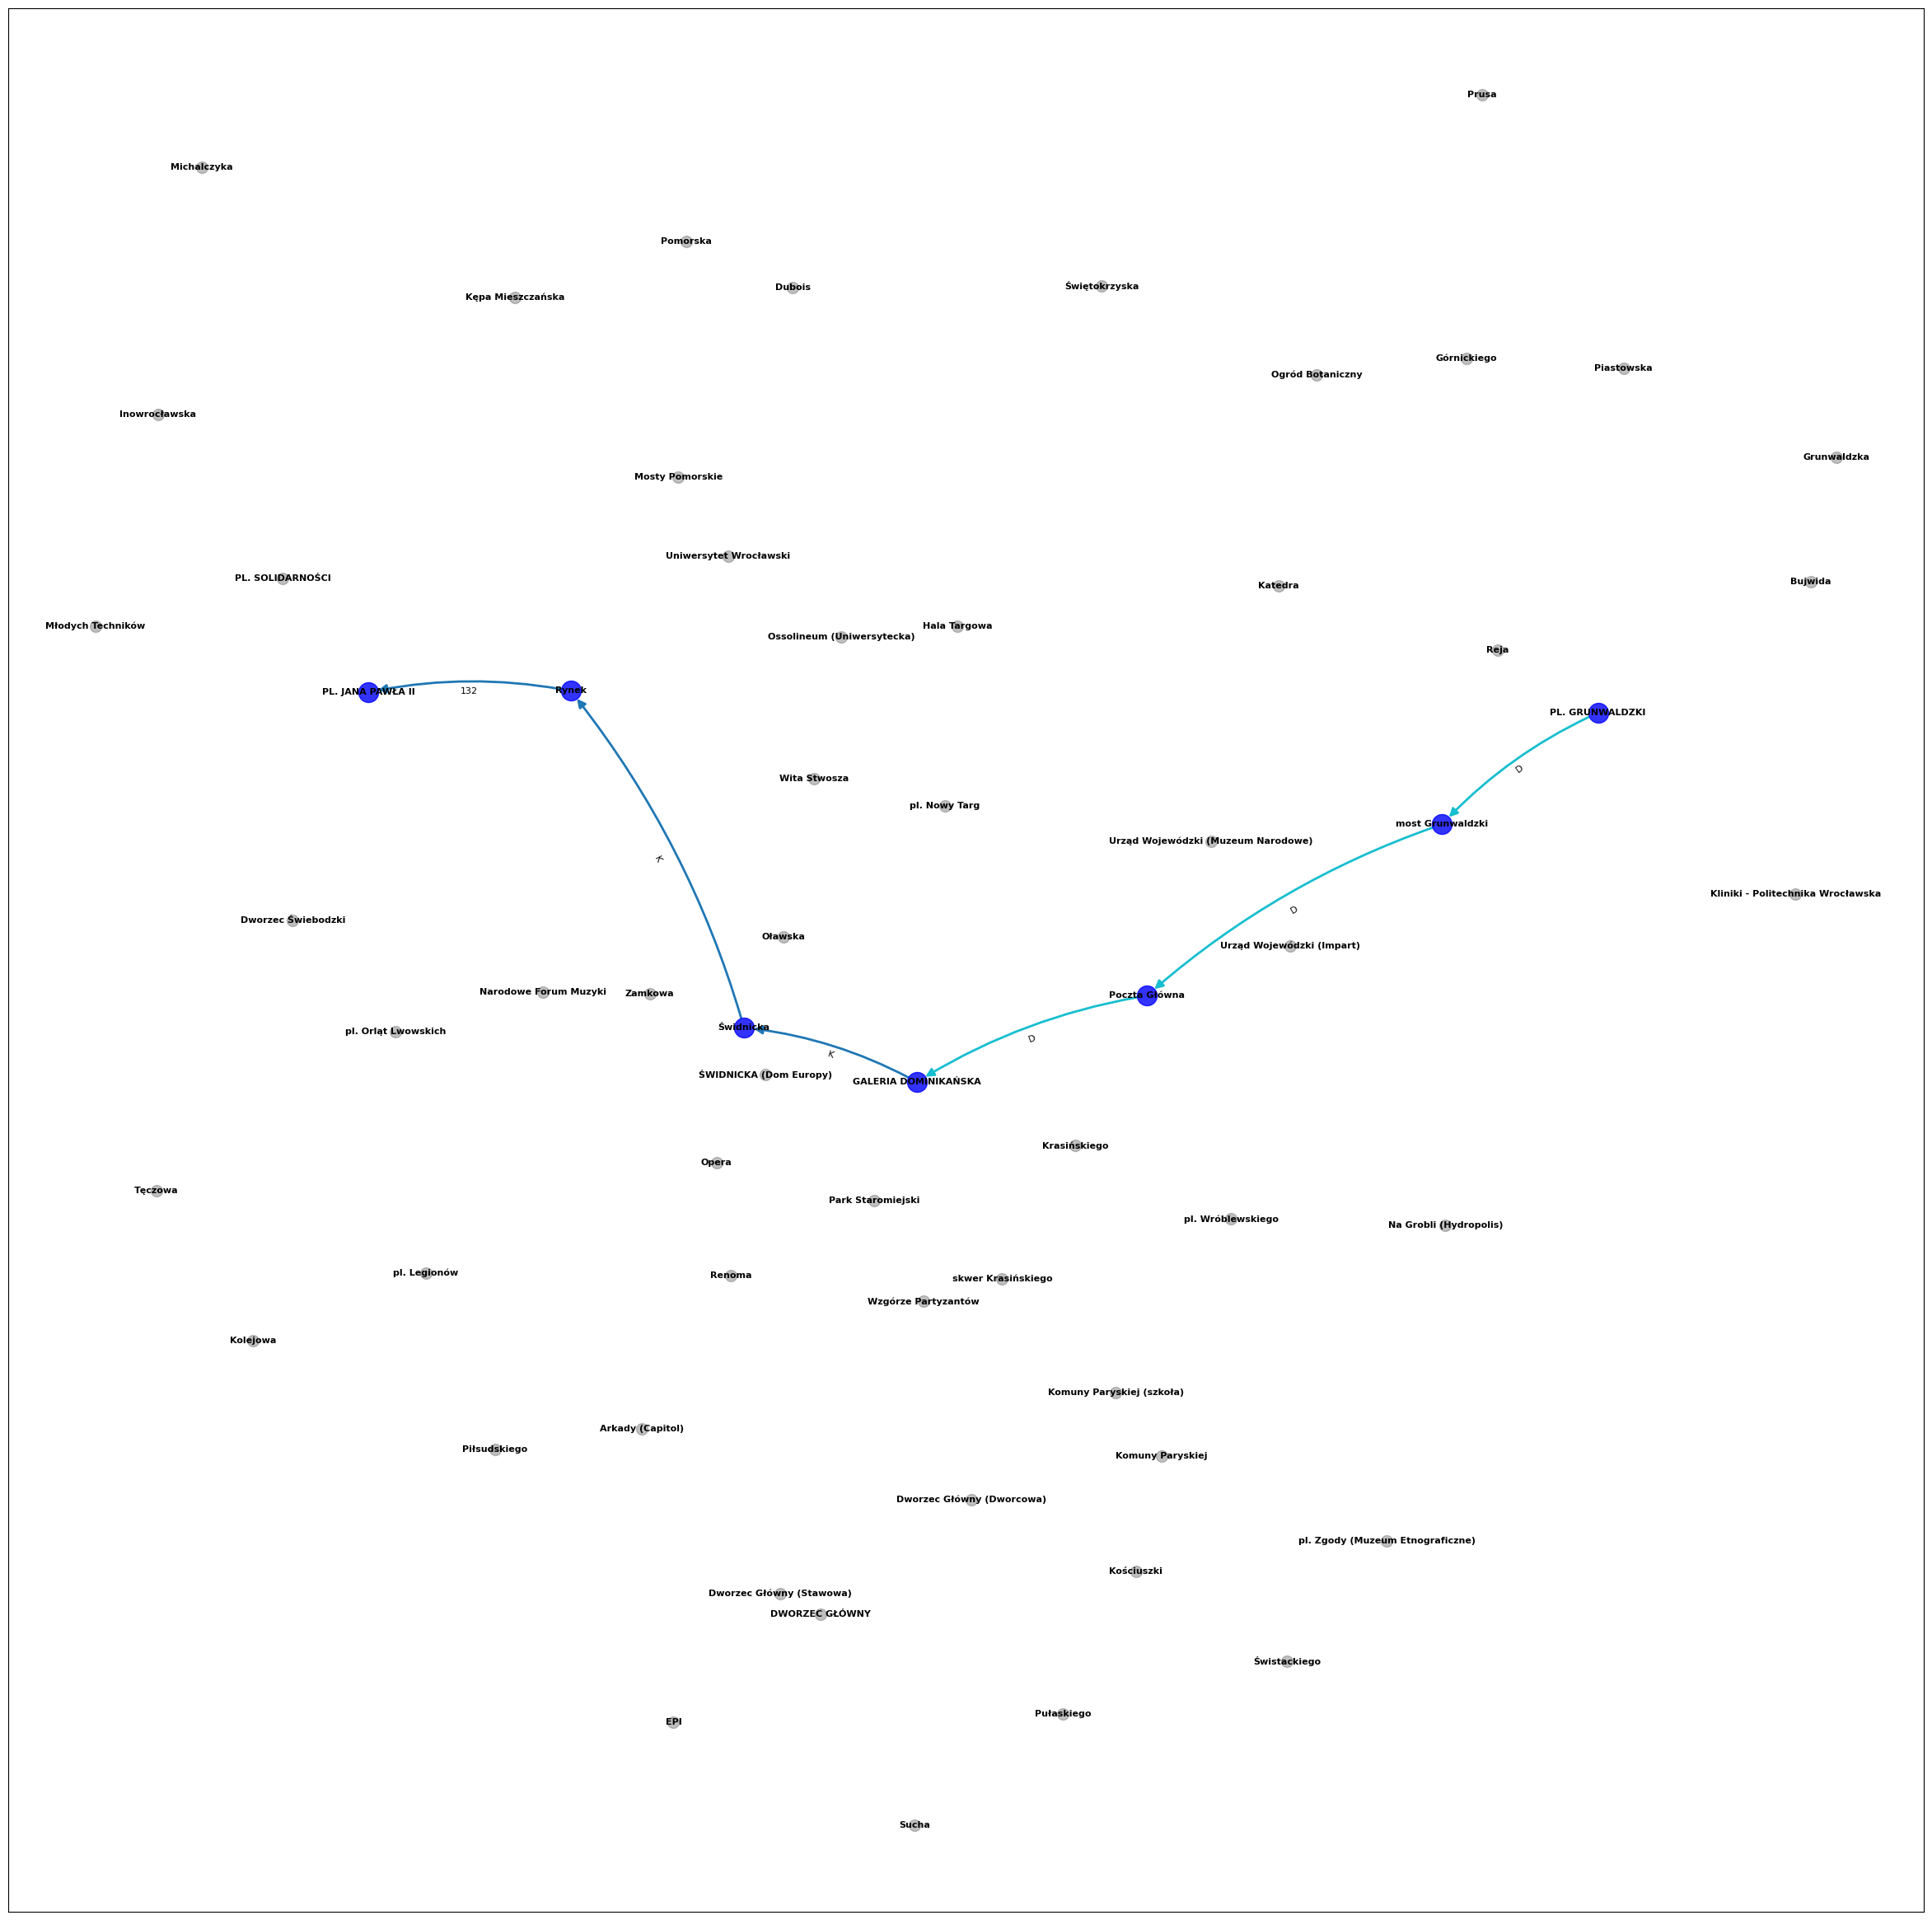

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

def draw_optimal_route(stop_graph, route_result, figsize=(30, 30), output_file=None):
    """
    Rysuje graf, ale pokazuje tylko przystanki i połączenia należące do optymalnej trasy oraz pobliskie przystanki.
    """
    G = nx.DiGraph()
    
    if route_result and 'route' in route_result:
        route_connections = route_result['route']
        edge_colors = []
        edge_labels = {}
        route_stops = set()
        
        for conn in route_connections:
            start_name = conn.start.name
            end_name = conn.end.name
            
            G.add_edge(start_name, end_name, label=f"Linia {conn.line}")
            edge_labels[(start_name, end_name)] = f"{conn.line}"
            edge_colors.append(f"C{hash(conn.line) % 10}")
            
            route_stops.add(start_name)
            route_stops.add(end_name)
        
        # Dodajemy pobliskie przystanki na podstawie odległości geograficznej
        nearby_stops = set()
        threshold_distance = 0.01  # Próg odległości 
        
        for stop_name in route_stops:
            stop = stop_graph[stop_name]
            for other_name, other_stop in stop_graph.items():
                if other_name not in route_stops:
                    distance = ((stop.lon - other_stop.lon) ** 2 + (stop.lat - other_stop.lat) ** 2) ** 0.5
                    if distance < threshold_distance:
                        nearby_stops.add(other_name)
                        G.add_node(other_name, pos=(other_stop.lon, other_stop.lat))
        
        pos = {stop: (stop_graph[stop].lon, stop_graph[stop].lat) for stop in route_stops.union(nearby_stops)}
        
        plt.figure(figsize=figsize)
        nx.draw_networkx_nodes(G, pos, nodelist=route_stops, node_size=300, node_color='blue', alpha=0.8)
        nx.draw_networkx_nodes(G, pos, nodelist=nearby_stops, node_size=100, node_color='gray', alpha=0.5)
        nx.draw_networkx_edges(G, pos, width=2, edge_color=edge_colors, 
                              connectionstyle='arc3,rad=0.1', arrows=True, arrowsize=15)
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
        nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold')
        
        if output_file:
            plt.savefig(output_file, dpi=300, bbox_inches='tight')
            print(f"Wykres zapisany do pliku: {output_file}")
        
    return plt

# Przykład użycia:
router = DijkstraRouter(stop_graph)
result = router.find_route("Wilczyce - Sosnowa", "Kołobrzeska", datetime.strptime("07:00:00", "%H:%M:%S"))

# Rysowanie grafu z optymalną trasą
plt_obj = draw_optimal_route(stop_graph, result, output_file="optymalna_trasa.png")
plt_obj.show()

In [ ]:
import heapq
import time
import random
import pandas as pd
from datetime import datetime, timedelta
from math import radians, sin, cos, sqrt, atan2, degrees
from collections import deque


class TSPSolver:
    def __init__(self, stop_graph, router):
        self.stop_graph = stop_graph
        self.router = router
        self.stops_cache = {}  # Cache for route calculations between stops

    def find_route_between_stops(self, start_stop, end_stop, start_time, optimization_type='t'):
        """Find the best route between two stops."""
        # Check if we have this route cached
        cache_key = (start_stop, end_stop, start_time.strftime('%H:%M:%S'), optimization_type)
        if cache_key in self.stops_cache:
            return self.stops_cache[cache_key]
        
        # Find the route
        route = self.router.find_route(start_stop, end_stop, start_time)
        
        # Cache the result
        self.stops_cache[cache_key] = route
        return route

    def calculate_solution_cost(self, solution, start_time, optimization_type='t'):
        """Calculate the cost of a solution (sequence of stops)."""
        total_time = 0
        total_transfers = 0
        current_time = start_time
        previous_stop = solution[0]
        
        for next_stop in solution[1:]:
            route = self.find_route_between_stops(previous_stop, next_stop, current_time, optimization_type)
            
            if route is None:
                # If no route is found, return an extremely high cost
                return float('inf'), float('inf')
            
            # Update the time for the next leg
            route_time_parts = route['total_cost'].split()
            hours = int(route_time_parts[0].replace('h', ''))
            minutes = int(route_time_parts[1].replace('min', ''))
            route_time_minutes = hours * 60 + minutes
            
            total_time += route_time_minutes
            total_transfers += route['transfers']
            
            # Update current time for next leg
            last_connection = route['route'][-1]
            current_time = last_connection.arrival_time
            previous_stop = next_stop
        
        # Add the return route to the starting point
        return_route = self.find_route_between_stops(solution[-1], solution[0], current_time, optimization_type)
        
        if return_route is None:
            return float('inf'), float('inf')
        
        # Add the return route cost
        route_time_parts = return_route['total_cost'].split()
        hours = int(route_time_parts[0].replace('h', ''))
        minutes = int(route_time_parts[1].replace('min', ''))
        route_time_minutes = hours * 60 + minutes
        
        total_time += route_time_minutes
        total_transfers += return_route['transfers']
        
        return total_time, total_transfers

    def get_cost(self, solution, start_time, optimization_type):
        """Get the cost based on optimization type."""
        time_cost, transfers_cost = self.calculate_solution_cost(solution, start_time, optimization_type)
        return time_cost if optimization_type == 't' else transfers_cost

    def generate_neighbors(self, solution, neighborhood_strategy='swap'):
        """Generate neighboring solutions based on strategy."""
        neighbors = []
        n = len(solution)
        
        # Always keep the first stop (start point) fixed
        if neighborhood_strategy == 'swap':
            # Swap strategy: exchange positions of two stops
            for i in range(1, n):
                for j in range(i+1, n):
                    neighbor = solution.copy()
                    neighbor[i], neighbor[j] = neighbor[j], neighbor[i]
                    neighbors.append(neighbor)
        
        elif neighborhood_strategy == '2-opt':
            # 2-opt strategy: reverse a segment of the tour
            for i in range(1, n-1):
                for j in range(i+1, n):
                    neighbor = solution.copy()
                    # Reverse the segment between i and j
                    neighbor[i:j+1] = neighbor[i:j+1][::-1]
                    neighbors.append(neighbor)
        
        elif neighborhood_strategy == 'insert':
            # Insert strategy: move a stop to a different position
            for i in range(1, n):
                for j in range(1, n):
                    if i != j:
                        neighbor = solution.copy()
                        stop = neighbor.pop(i)
                        neighbor.insert(j, stop)
                        neighbors.append(neighbor)
        
        elif neighborhood_strategy == 'hybrid':
            # Mix of strategies for diversification
            # Add a subset of neighbors from each strategy
            swap_neighbors = self.generate_neighbors(solution, 'swap')
            opt_neighbors = self.generate_neighbors(solution, '2-opt')
            insert_neighbors = self.generate_neighbors(solution, 'insert')
            
            # Randomly select neighbors from each strategy
            neighbors.extend(random.sample(swap_neighbors, min(5, len(swap_neighbors))))
            neighbors.extend(random.sample(opt_neighbors, min(5, len(opt_neighbors))))
            neighbors.extend(random.sample(insert_neighbors, min(5, len(insert_neighbors))))
        
        elif neighborhood_strategy == 'adaptive':
            # Adaptive sampling based on solution size
            if n <= 5:
                # For small problems, use all neighbors
                neighbors = self.generate_neighbors(solution, 'swap')
                neighbors.extend(self.generate_neighbors(solution, '2-opt'))
            else:
                # For larger problems, use a random subset
                subset_size = max(10, n)  # At least 10 neighbors
                
                # Generate different types and sample from them
                swap_neighbors = self.generate_neighbors(solution, 'swap')
                opt_neighbors = self.generate_neighbors(solution, '2-opt')
                
                if len(swap_neighbors) > 0:
                    neighbors.extend(random.sample(swap_neighbors, min(subset_size // 2, len(swap_neighbors))))
                if len(opt_neighbors) > 0:
                    neighbors.extend(random.sample(opt_neighbors, min(subset_size // 2, len(opt_neighbors))))
        
        return neighbors

    def tabu_search(self, start_stop, stops_to_visit, start_time, optimization_type='t', 
                   max_iterations=100, tabu_size=None, aspiration=False, sampling_strategy='swap'):

        start_measure = time.time()
        
        # Create a complete list of stops including the start stop
        all_stops = [start_stop] + stops_to_visit
        
        # Set tabu size based on problem size if not specified
        if tabu_size is None:
            tabu_size = len(stops_to_visit)
        
        # Initialize current solution (start with stops in the given order)
        current_solution = all_stops.copy()
        
        # Initialize the best solution
        best_solution = current_solution.copy()
        best_cost = self.get_cost(current_solution, start_time, optimization_type)
        
        # Initialize tabu list as a deque for efficient FIFO operations
        tabu_list = deque(maxlen=tabu_size)
        
        # Track iterations without improvement
        no_improvement_count = 0
        diversification_threshold = max(10, len(stops_to_visit) * 2)
        
        for iteration in range(max_iterations):
            # Generate neighbors
            neighbors = self.generate_neighbors(current_solution, sampling_strategy)
            
            # Find best non-tabu neighbor
            best_neighbor = None
            best_neighbor_cost = float('inf')
            
            for neighbor in neighbors:
                # Check if the move is tabu
                move_is_tabu = str(neighbor) in tabu_list
                
                # Calculate the cost
                neighbor_cost = self.get_cost(neighbor, start_time, optimization_type)
                
                # Check aspiration criteria: accept tabu move if it's better than the best solution
                if aspiration and move_is_tabu and neighbor_cost < best_cost:
                    move_is_tabu = False
                
                # Update best neighbor if not tabu or meets aspiration
                if not move_is_tabu and neighbor_cost < best_neighbor_cost:
                    best_neighbor = neighbor
                    best_neighbor_cost = neighbor_cost
            
            # If no non-tabu neighbor is found, break
            if best_neighbor is None:
                break
            
            # Update current solution
            current_solution = best_neighbor
            
            # Add to tabu list
            tabu_list.append(str(current_solution))
            
            # Update best solution if improved
            if best_neighbor_cost < best_cost:
                best_solution = current_solution.copy()
                best_cost = best_neighbor_cost
                no_improvement_count = 0
            else:
                no_improvement_count += 1
            
            # Diversification strategy: if no improvement for a while, perturb the solution
            if no_improvement_count >= diversification_threshold:
                # Perform a random permutation on the non-fixed part of the solution
                shuffled_part = current_solution[1:]
                random.shuffle(shuffled_part)
                current_solution = [current_solution[0]] + shuffled_part
                no_improvement_count = 0
        
        end_measure = time.time()
        
        # Reconstruct the full route details
        full_route = []
        total_time = 0
        total_transfers = 0
        current_time_obj = start_time
        previous_stop = best_solution[0]
        
        for next_stop in best_solution[1:] + [best_solution[0]]:  # Add start stop at the end to complete the cycle
            route_segment = self.find_route_between_stops(previous_stop, next_stop, current_time_obj, optimization_type)
            
            if route_segment:
                full_route.extend(route_segment['route'])
                
                # Update counters and time
                route_time_parts = route_segment['total_cost'].split()
                hours = int(route_time_parts[0].replace('h', ''))
                minutes = int(route_time_parts[1].replace('min', ''))
                route_time_minutes = hours * 60 + minutes
                
                total_time += route_time_minutes
                total_transfers += route_segment['transfers']
                
                # Update current time for next leg
                if route_segment['route']:
                    current_time_obj = route_segment['route'][-1].arrival_time
                
                previous_stop = next_stop
        
        # Calculate total metrics
        hours = total_time // 60
        minutes = total_time % 60
        total_cost = f"{int(hours)}h {int(minutes)}min"
        
        return {
            'route': full_route,
            'total_cost': total_cost,
            'calculation_time': end_measure - start_measure,
            'transfers': total_transfers,
            'best_solution': best_solution
        }

def find_and_print_route(tsp_solver, start_stop, stops_to_visit, start_time_str, optimization_type,
                         tabu_size=None, aspiration=False, sampling_strategy='swap'):
    start_time = datetime.strptime(start_time_str, "%H:%M:%S")
    
    result = tsp_solver.tabu_search(
        start_stop, 
        stops_to_visit, 
        start_time, 
        optimization_type=optimization_type,
        tabu_size=tabu_size,
        aspiration=aspiration,
        sampling_strategy=sampling_strategy
    )
    
    if result:
        print("\nHarmonogram przejazdu:")
        for connection in result['route']:
            print(f"Linia: {connection.line}, "
                  f"Z: {connection.start.name} o {connection.departure_time.strftime('%H:%M:%S')}, "
                  f"Do: {connection.end.name} o {connection.arrival_time.strftime('%H:%M:%S')}")
        
        print(f"Liczba przesiadek: {result['transfers']}")
        
        if optimization_type == 't':
            print(f"\nKoszt trasy (czas): {result['total_cost']}", file=sys.stderr)
        else:
            print(f"\nKoszt trasy (przesiadki): {result['transfers']}", file=sys.stderr)
        
        print(f"Czas obliczeń: {result['calculation_time']:.4f} sekund", file=sys.stderr)
        
        return result
    else:
        print("Nie znaleziono trasy.")
        return None

# Main function to process input and execute the algorithm
def main():
    import sys
    
    # Read input
    start_stop = "PL. GRUNWALDZKI"  # Example start stop
    stops_to_visit = ["PL. JANA PAWŁA II", "C.H. Korona", "Kołobrzeska"]  # Example stops to visit
    optimization_type = 't'
    start_time_str = '7:00:00'  # Example start time
    
    # Create router instance using your existing DijkstraRouter class
    router = DijkstraRouter(stop_graph)
    
    # Create TSP solver
    tsp_solver = TSPSolver(stop_graph, router)
    
    # Find optimal route
    # Basic Tabu Search solution (10 points)
    result_a = find_and_print_route(tsp_solver, start_stop, stops_to_visit, start_time_str, optimization_type)
    
    # Tabu size adaptation based on list length (5 points)
    adaptive_tabu_size = len(stops_to_visit) * 2 if len(stops_to_visit) > 3 else 5
    result_b = find_and_print_route(tsp_solver, start_stop, stops_to_visit, start_time_str, 
                                  optimization_type, tabu_size=adaptive_tabu_size)
    
    # Aspiration criteria (5 points)
    result_c = find_and_print_route(tsp_solver, start_stop, stops_to_visit, start_time_str, 
                                  optimization_type, aspiration=True)
    
    # Advanced neighborhood sampling strategy (10 points)
    result_d = find_and_print_route(tsp_solver, start_stop, stops_to_visit, start_time_str, 
                                  optimization_type, sampling_strategy='adaptive')
    
    # Use the best result for actual output
    best_result = min([result_a, result_b, result_c, result_d], 
                      key=lambda x: x['transfers'] if optimization_type == 'p' else 
                                  int(x['total_cost'].split('h')[0])*60 + int(x['total_cost'].split(' ')[1].replace('min','')))
    
    # Output the final best route (already printed by find_and_print_route)
    return best_result

if __name__ == "__main__":
    main()


Harmonogram przejazdu:
Linia: D, Z: PL. GRUNWALDZKI o 07:01:00, Do: Kochanowskiego o 07:04:00
Linia: D, Z: Kochanowskiego o 07:04:00, Do: Śniadeckich o 07:06:00
Linia: D, Z: Śniadeckich o 07:06:00, Do: Zacisze o 07:07:00
Linia: D, Z: Zacisze o 07:07:00, Do: Kwidzyńska o 07:09:00
Linia: D, Z: Kwidzyńska o 07:09:00, Do: Brücknera o 07:11:00
Linia: 130, Z: Brücknera o 07:13:00, Do: C.H. Korona o 07:15:00
Linia: 121, Z: C.H. Korona o 07:16:00, Do: Brücknera o 07:18:00
Linia: 121, Z: Brücknera o 07:18:00, Do: Kwidzyńska o 07:20:00
Linia: 121, Z: Kwidzyńska o 07:20:00, Do: Zacisze o 07:21:00
Linia: 121, Z: Zacisze o 07:21:00, Do: Śniadeckich o 07:22:00
Linia: 121, Z: Śniadeckich o 07:22:00, Do: Kochanowskiego o 07:25:00
Linia: 121, Z: Kochanowskiego o 07:25:00, Do: Bujwida o 07:27:00
Linia: 121, Z: Bujwida o 07:27:00, Do: PL. GRUNWALDZKI o 07:29:00
Linia: D, Z: PL. GRUNWALDZKI o 07:31:00, Do: most Grunwaldzki o 07:32:00
Linia: D, Z: most Grunwaldzki o 07:32:00, Do: Poczta Główna o 07:34:00


NameError: name 'sys' is not defined